In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

# Inspect and Clean Data

In [2]:
df = pd.read_csv('./titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# drop unimportant columns.  Since the cabin variable correlates with the fair and pclass variables, we can safely
# drop this variable for future analysis
df.drop(labels = ['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
df.groupby('Embarked').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,
C,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


In [8]:
# The embarked variable seems to be highly correlated with the Fare and Ticket class of a passenger.
# It is not necessarily predictive in itself, so we're going to drop the variable for further analysis.
df.drop(labels = ['Embarked'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [9]:
# let's convert Sex to 0s and 1s for easier numerical analysis
df.Sex = df.Sex.replace({'male': 1, 'female': 0})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


# Group By Survival

In [10]:
group = df.groupby('Survived').mean()
group

,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,,,,,,
0,2.531876,0.852459,30.626179,0.553734,0.329690,22.117887
1,1.950292,0.318713,28.343690,0.473684,0.464912,48.395408


We can immediately see several important differences here.

1. <b>Pclass</b>: Passengers who survive were much more likely to be in a higher class
2. <b>Sex</b>: Females were much more likely to survive than men.
3. <b>Parch</b>: Passengers with more parents/children were more likely to survive.  This makes intuitive sense, since women with children were prioritized for the lifeboats.
4. <b>Fare</b>: Passengers who survived paid a much higher fare on average.

# Continuous Variable Exploration

In [11]:
df.Fare.mean()

32.2042079685746

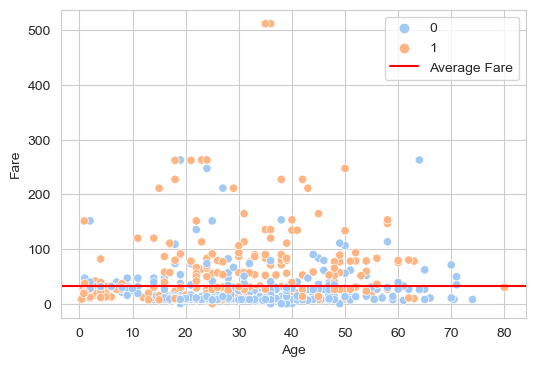

In [12]:
plt.figure(figsize = (6,4))

sns.scatterplot(data = df, x = 'Age', y = 'Fare', hue = 'Survived')
plt.axhline(y = df.Fare.mean(), color = 'red', label = 'Average Fare')

plt.legend()
plt.show()

# Discrete Variable Exploration

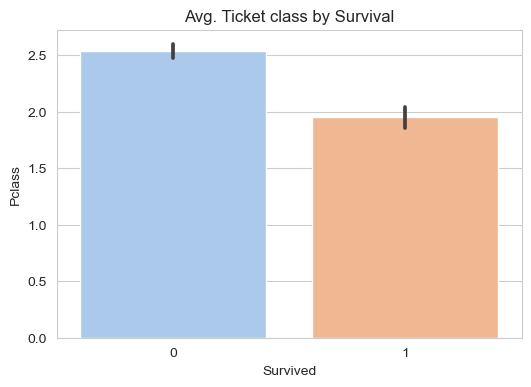

In [13]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Survived', y = 'Pclass')

plt.title("Avg. Ticket class by Survival")
plt.show()

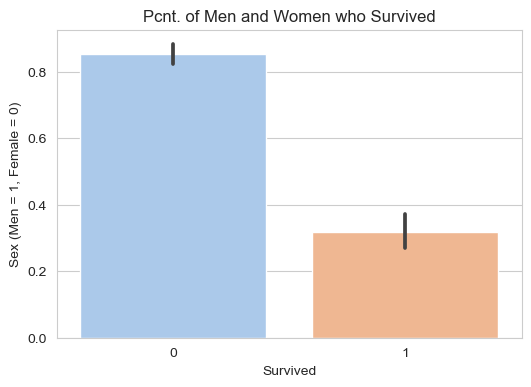

In [14]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Survived', y = 'Sex')

plt.title("Pcnt. of Men and Women who Survived")
plt.ylabel("Sex (Men = 1, Female = 0)")
plt.show()

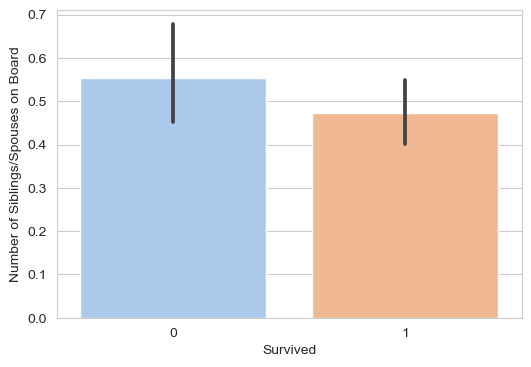

In [15]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Survived', y = 'SibSp')

plt.ylabel("Number of Siblings/Spouses on Board")
plt.show()

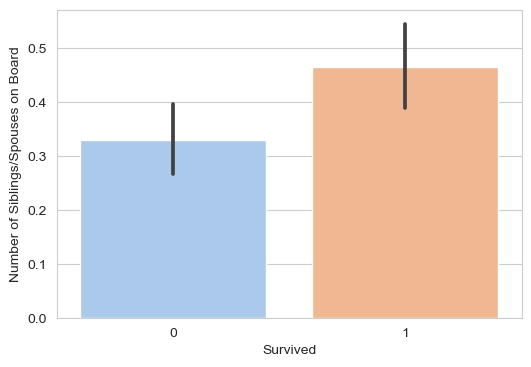

In [16]:
plt.figure(figsize = (6,4))

sns.barplot(data = df, x = 'Survived', y = 'Parch')

plt.ylabel("Number of Siblings/Spouses on Board")
plt.show()

# Feature Selection

In [17]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [18]:
def generate_diffs_and_graph(col, len_a, df, pos_col, neg_col):
    # generated permuted differences
    actual_diff = group.loc[pos_col][col] - group.loc[neg_col][col]
    diffs = [perm_fun(df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

## Significance Testing

Let's try to find out which independent variables are significantly different from each other based on survival rate.

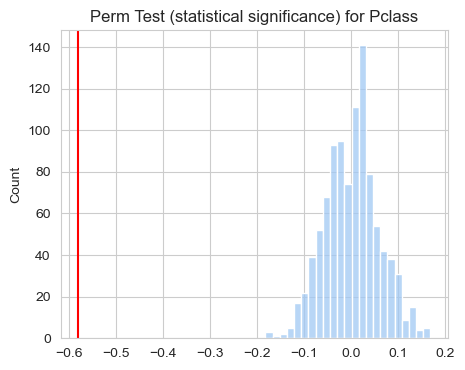

p-val: 0.0


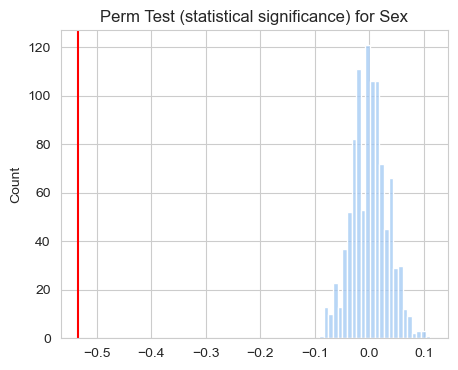

p-val: 0.0


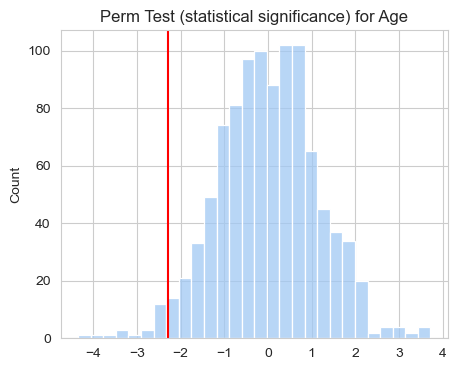

p-val: 0.04


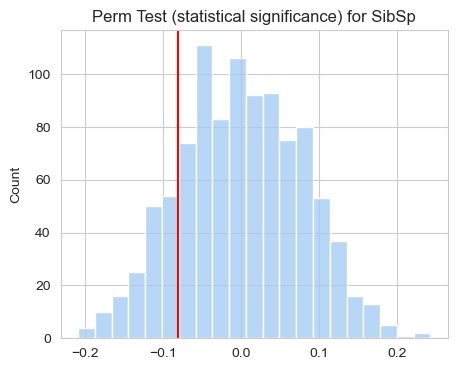

p-val: 0.32


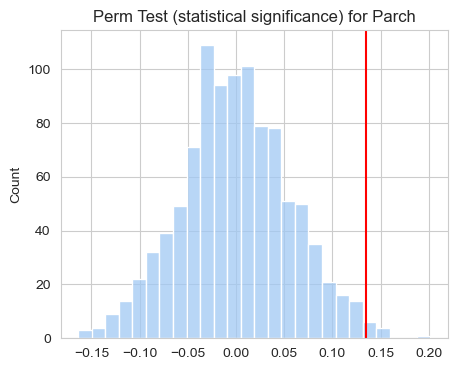

p-val: 0.02


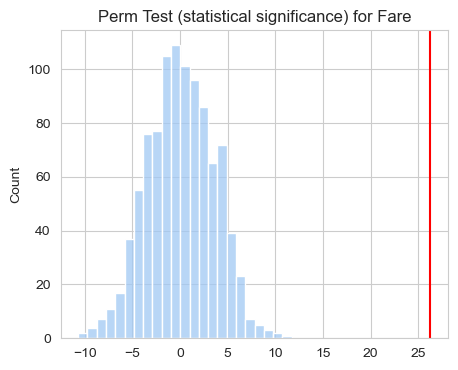

p-val: 0.0


In [19]:
significant_vars = []
len_a = df.Survived.value_counts().loc[1]

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a, df, 1, 0)
    if (p_val <= .03):
        significant_vars.append(col)

In [20]:
# Since these variables seem to be reliable predictors of survival, we will use these variables in our model
significant_vars

['Pclass', 'Sex', 'Parch', 'Fare']

# Correlation Heatmap

<AxesSubplot:>

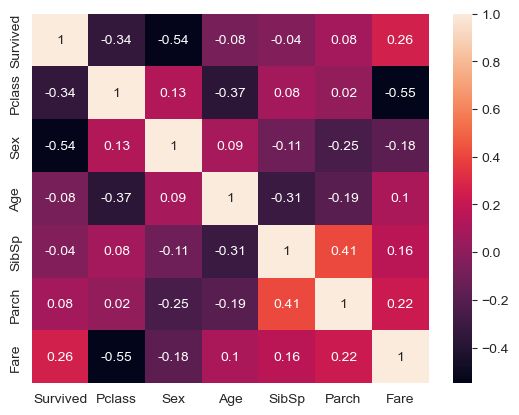

In [21]:
sns.heatmap(df.corr().round(2), annot = True)

<b>Pclass</b> and <b>Fare</b> seem to have a strong correlation, as Pclass goes down, Fare increases. In a more involved modeling process, we may want to consider combining these features into one.

# Machine Learning Model

In [22]:
X = df[significant_vars]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 21)

In [23]:
xgb = XGBClassifier(n_estimators = 100, max_depth = 6, learning_rate = .05, gamma = 1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
predictions = xgb.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7821229050279329
Precision: 0.8070175438596491
Recall: 0.6216216216216216


# Hypertune Parameters using Cross-Validation

In [ ]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6],
    "gamma": [1, 5],
    "learning_rate": [.01, .05]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
# retrain model with the hypertuned parameters
tuned_model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"],
                      gamma = grid.best_params_["gamma"], learning_rate = grid.best_params_["learning_rate"])
tuned_model.fit(X_train, y_train)

In [ ]:
# see how important each feature is
list(zip(significant_vars, tuned_model.feature_importances_))

In [ ]:
predictions = tuned_model.predict(X_test)

tuned_accuracy = accuracy_score(y_test, predictions)
tuned_precision = precision_score(y_test, predictions)
tuned_recall = recall_score(y_test, predictions)

print("Accuracy:", tuned_accuracy)
print("Precision:", tuned_precision)
print("Recall:", tuned_recall)

In [ ]:
metrics_df = pd.DataFrame(data = [[accuracy, precision, recall], [tuned_accuracy, tuned_precision, tuned_recall]],
                 index = ['Before Tuning', 'After Tuning'],
                 columns = ['Accuracy', 'Precision', 'Recall'])

metrics_df